In [1]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
import re
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain_community.vectorstores import FAISS
import os
from uuid import uuid4

def load_database(_embedding, faiss_idx):
    """
    Загружает или создает локальную базу данных FAISS для хранения векторных представлений.

    :param _embedding: Экземпляр модели эмбеддингов.
    :param faiss_idx: Путь к локальному индексу FAISS.
    :return: Экземпляр FAISS базы данных.
    """
    if os.path.exists(faiss_idx) and os.path.isdir(faiss_idx):
        db = FAISS.load_local(faiss_idx, _embedding, allow_dangerous_deserialization=True)
    else:
        db = FAISS.from_texts("Hello pipl", _embedding)
        db.save_local(faiss_idx)
    return db



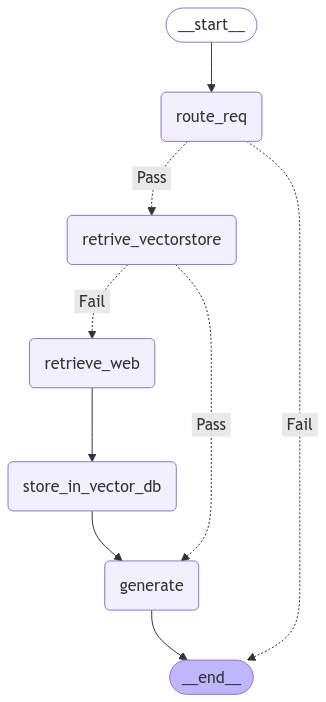

In [10]:
from typing import Literal, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
import re

from src.ya_search_api import YandexSearchAPI, YandexSearchConfig, YandexSearchParser

config = YandexSearchConfig(
    api_key="",
    groups_on_page = 5,
    docs_in_group = 1,
    max_passages = 2,
    l10n = "LOCALIZATION_RU",
    region = "225"
)
search_api = YandexSearchAPI(config)


class AgentState(TypedDict):
    messages: str
    context_messages: list
    is_test: str
    is_rag: str
    is_full_answ: str
    final_answ: dict

def route_req(state: AgentState) -> Literal["Pass", "Fail"]:
    """
    Функция для определения следующего шага в зависимости от категории.
    """
    print("--- ВЫЗОВ АГЕНТА route_req ---")
    answer = state["messages"]

    multiple_choice_pattern = re.compile(r"^\d+\.\s+", re.MULTILINE)
    if multiple_choice_pattern.search(str(answer)):
        print("--- Текст является тестом ---")
        return {"messages" : state['messages'],
                "context_messages" : state['context_messages'],
                "is_test": "Pass",
                "is_rag": state['is_rag'],
                "is_full_answ": 'test_answer',
                "final_answ": state['final_answ']}
    
    
    model = ChatOpenAI(temperature=0, streaming=False, model="gpt-4-turbo")
    system_message = SystemMessage(content=(
        """
        Ты интеллектуальный ассистент, задача которого — валидировать контент.
        Твоя цель — определять, является ли текст вопросом на который необходимо ответить.
        Отвечай либо Yes , либо No.
        """
    ))
    human_message = HumanMessage(content=f"Отрывок: {answer}")
    messages = [system_message, human_message]
    response = model.invoke(messages).content
    if response.lower() == 'yes':
        print("--- Текст является вопросом ---")
        return {"messages" : state['messages'],
            "context_messages" : state['context_messages'],
            "is_test": "Pass",
            "is_rag": state['is_rag'],
            "is_full_answ": 'full_answer',
            "final_answ": state['final_answ']}


    print("--- Текст не является вопросом и не является тестом---")
    final_answer = {
        "answer": "null",
        "reasoning": "Запрос не является вопросом на который можно однозначно ответить или выбрать правильный вариант ответа.",
        "sources": []
    }
    return {"messages" : state['messages'],
            "context_messages" : state['context_messages'],
            "is_test": "Fail",
            "is_rag": state['is_rag'],
            "is_full_answ": state['is_full_answ'],
            "final_answ": final_answer}

def retrive_vectorstore(state: AgentState):
    """
    Вызывает агентную модель для генерации ответа на основе текущего состояния.
    Учитывая вопрос, агент принимает решение: использовать инструмент поиска или завершить выполнение.

    Аргументы:
        state (messages): Текущее состояние

    Возвращает:
        dict: Обновленное состояние с добавленным ответом агента в список сообщений
    """
    print("--- ВЫЗОВ АГЕНТА Retriver_Valid ---")
    message = state["messages"]

    database = load_database(embeddings, 'db/prod_db')

    retriever_data = database.similarity_search(message, k=3, filter={"table": "ITMO"})

    system_message = SystemMessage(content=(
        """
        Ты интеллектуальный ассистент, задача которого — валидировать контент.
        Твоя цель — определять, можно ли из контаекста текста ответить на вопрос.
        Отвечай либо Yes , либо No.
        """
    ))


    model = ChatOpenAI(temperature=0, streaming=False, model="gpt-4-turbo")
    valid_docs = []

    for idx, chunk in enumerate(retriever_data):
        human_message = HumanMessage(content=f"Тема запроса: {message}; Отрывок: {chunk.page_content}")
        messages = [system_message, human_message]
        response = model.invoke(messages).content

        print(f"--- Чанк {idx} валидный? - {response} ---")

        if response.lower() == 'yes':
            valid_docs.append({"text" : chunk.page_content,
                                "url" : chunk.metadata['url']})

    print(f"--- Всего чанков отобрано {len(valid_docs)} ---")

    if len(valid_docs) != 0:
        print(f"--- Начинаем генерацию ответа ---")
        return {"messages" : state['messages'],
                "context_messages" : valid_docs,
                "is_test":  state['is_test'],
                "is_rag": "Pass",
               "is_full_answ": state['is_full_answ'],
                "final_answ": state['final_answ']}
    else:
        print(f"--- переходим в поиск в интернете ---")
        return {"messages" : state['messages'],
                "context_messages" : state['context_messages'],
                "is_test":  state['is_test'],
                "is_rag": "Fail",
                "is_full_answ": state['is_full_answ'],
                "final_answ": state['final_answ']}


def retrieve_web(state: AgentState):
    """Функция-заглушка для инструмента поиска в интернете"""
    print("---TOOL: WEB SEARCH TOOL---")

    query = state["messages"]
    response = search_api.search(query)
    valid_docs = []

    if response:
        print("Ответ от API получен, парсим XML...")
        parsed_results = YandexSearchParser.parse(response)

        model = ChatOpenAI(temperature=0, streaming=False, model="gpt-4-turbo")
        system_message = SystemMessage(content=(
                """
                Ты интеллектуальный ассистент, задача которого — валидировать контент.
                Твоя цель — определять, можно ли из контаекста текста ответить на вопрос.
                Отвечай либо Yes , либо No.
                """
        ))

        for idx, doc in enumerate(parsed_results, start=1):
            if len(valid_docs) >= 3:
                break

            url = doc['url']
            print(f"\nДокумент {idx}:")
            print(f"URL: {url}")

            passages_text = ', '.join(doc['passages'])
            human_message = HumanMessage(content=f"Тема запроса: {query}; Отрывок: {passages_text}")
            messages = [system_message, human_message]
            response = model.invoke(messages).content
            print(f"--- Чанк {idx} валидный? - {response} ---")
            print(f"--- {passages_text} ---")
            if response.lower() == 'yes':
                valid_docs.append({"text" : passages_text,
                                   "url" : url})
            else:
                passages_text = doc.get('extended_text', '')
                human_message = HumanMessage(content=f"Тема запроса: {query}; Отрывок: {passages_text}")
                messages = [system_message, human_message]
                response = model.invoke(messages).content
                print(f"--- Чанк {idx} валидный? - {response} ---")
                print(f"--- {passages_text} ---")
                if response.lower() == 'yes':
                    valid_docs.append({"text" : passages_text,
                                        "url" : url})




    print(f"--- Всего чанков отобрано {len(valid_docs)} ---")
    state['context_messages'] = valid_docs

    return {"messages" : state['messages'],
            "context_messages" : valid_docs,
            "is_test":  state['is_test'],
            "is_rag": state['is_rag'],
            "is_full_answ": state['is_full_answ'],
            "final_answ": state['final_answ']}


def store_in_vector_db(state: AgentState):
    print("---STORE IN VECTOR DB---")
    doc_list = []
    context = state['context_messages']
    database = load_database(embeddings, 'db/prod_db')

    for chunk in context:
        cur_doc = Document(page_content = chunk['text'], metadata={'url' : chunk['url'], "table": "ITMO"})
        doc_list.append(cur_doc)

    uuids = [str(uuid4()) for _ in range(len(doc_list))]

    database.add_documents(documents=doc_list, ids=uuids)

    database.save_local('db/prod_db')
    
    return {"messages" : state['messages'],
            "context_messages" : state['context_messages'],
            "is_test":  state['is_test'],
            "is_rag": state['is_rag'],
            "is_full_answ": state['is_full_answ'],
            "final_answ": state['final_answ']}

def generate(state: AgentState):
    print("---GENERATE RESPONSE---")
    message = state["messages"]
    context = state['context_messages']
    is_full_answis_answer = state['is_full_answ']
    result_context = ''
    urls_list = []
    for chunk in context:
        result_context = result_context + chunk['text'] + "\n"
        urls_list.append(chunk['url'])

    if is_full_answis_answer == 'test_answer':
        model = ChatOpenAI(temperature=0, streaming=False, model="gpt-4-turbo")

        system_message = SystemMessage(content=(
                f"""
                Ты — интеллектуальный помощник, задача которого — анализировать вопрос и выбирать правильный вариант ответа на основе предоставленного контекста.
                **Инструкция:**
                1. Внимательно прочитай контекст, содержащий информацию, необходимую для ответа на вопрос.
                2. Ознакомься с самим вопросом и предложенными вариантами ответов.
                3. Определи правильный вариант ответа на основе контекста.
                4. Вопрос содержит варианты ответов (пронумерованные обычно от 1 до 10), выбери один правильный вариант и укажи его номер.

                В ответе верни лишь число правильного ответа.
                """
        ))

        human_message = HumanMessage(content=f"Вопрос: {message}, Контекст: {result_context}")

        print(f'--- ВОПРОС ----\n{message}')
        print(f'--- КОНТЕКСТ ----\n{result_context}')
        messages = [system_message, human_message]
        response = model.invoke(messages).content
        match = re.findall(r'\b(10|[1-9])\b', response)[0]
        print(f'--- ОТВЕТ ----\n{match}')
        answer = match
        reasoning = result_context
        sourses = urls_list


    elif is_full_answis_answer == 'full_answer':
        model = ChatOpenAI(temperature=0.5, streaming=False, model="gpt-4-turbo")

        system_message = SystemMessage(content=(
                f"""
                Ты — интеллектуальный помощник, задача которого — анализировать вопрос и развернуто ответить на него на основе предоставленного контекста.
                **Инструкция:**
                1. Внимательно прочитай контекст, содержащий информацию, необходимую для ответа на вопрос.
                2. Ознакомься с самим вопросом.
                3. Сформируй ответ на вопрос.

                В ответе напиши кратко вариант ответа основываясь на предоставленный контекст.
                """
        ))

        human_message = HumanMessage(content=f"Вопрос: {message}, Контекст: {result_context}")

        print(f'--- ВОПРОС ----\n{message}')
        print(f'--- КОНТЕКСТ ----\n{result_context}')
        messages = [system_message, human_message]
        response = model.invoke(messages).content
        print(f'--- ОТВЕТ ----\n{response}')
        answer = "null"
        reasoning = response
        sourses = urls_list


    final_answer = {
        "answer": answer,
        "reasoning": reasoning,
        "sources": sourses
    }
    return {"messages" : state['messages'],
            "context_messages" : state['context_messages'],
            "is_test":  state['is_test'],
            "is_rag": state['is_rag'],
            "is_full_answ": state['is_full_answ'],
            "final_answ": final_answer}

# Создаем граф состояний
workflow = StateGraph(AgentState)
workflow.add_node("route_req", route_req)
workflow.add_node("retrive_vectorstore", retrive_vectorstore)

workflow.add_node("retrieve_web", retrieve_web)
workflow.add_node("store_in_vector_db", store_in_vector_db)
workflow.add_node("generate", generate)

# Устанавливаем начальную точку
workflow.set_entry_point("route_req")

workflow.add_conditional_edges(
    "route_req",
    lambda state: state["is_test"],
    {
        "Pass": "retrive_vectorstore",
        "Fail": END
    }
)

workflow.add_conditional_edges(
    "retrive_vectorstore",
    lambda state: state["is_rag"],
    {
        "Pass": "generate",
        "Fail": "retrieve_web",
    },
)

workflow.add_edge("retrieve_web", "store_in_vector_db")
workflow.add_edge("store_in_vector_db", "generate")


# Завершаем генерацией
workflow.add_edge("generate", END)

# Компилируем граф
app_workflow = workflow.compile()

display(Image(app_workflow.get_graph().draw_mermaid_png()))


In [14]:
yep_test = 'В каком году Университет ИТМО был включён в число Национальных исследовательских университетов России?\n1. 2007\n2. 2009\n3. 2011\n4. 2015'
none_test = 'В каком рейтинге (по состоянию на 2021 год) ИТМО впервые вошёл в топ-400 мировых университетов?\n1. ARWU (Shanghai Ranking)\n2. Times Higher Education (THE) World University Rankings\n3. QS World University Rankings\n4. U.S. News & World Report Best Global Universities'
govno_answ = 'В каком рейтинге (по состоянию на 2021 год) ИТМО впервые вошёл в топ-400 мировых университетов?'
govno = 'дываловыдлоадволыаловыдлоа'
#state = app.invoke({"message": yep_test, "is_answer": None})


final_answer = {
        "answer": "null",
        "reasoning": "Запрос не является вопросом на который можно однозначно ответить или выбрать правильный вариант ответа.",
        "sources": []
    }

In [15]:
inputs = {"messages" : none_test,
            "context_messages" : [],
            "is_test": None,
            "is_rag": None,
            "is_full_answ": None,
            "final_answ": final_answer}

state = app_workflow.invoke(inputs)

--- ВЫЗОВ АГЕНТА route_req ---
--- Текст является тестом ---
--- ВЫЗОВ АГЕНТА Retriver_Valid ---
--- Всего чанков отобрано 0 ---
--- переходим в поиск в интернете ---
---TOOL: WEB SEARCH TOOL---
Ответ от API получен, парсим XML...

Документ 1:
URL: https://news.itmo.ru/ru/news/9704/
--- Чанк 1 валидный? - Yes ---
--- Напомним, что в этом году Университет ИТМО вошел в число 400 лучших вузов планеты по версии QS World University Rankings, топ-1000 Шанхайского рейтинга ARWU, и в «бриллиантовую» лигу российских вузов в рейтинге RUR. ---

Документ 2:
URL: https://www.timeshighereducation.com/world-university-rankings/2021/world-ranking
--- Чанк 2 валидный? - No ---
--- The table is based on 13 carefully calibrated performance indicators that measure an institution’s performance across four areas: teaching, research, knowledge transfer and. ---
--- Чанк 2 валидный? - No ---
--- The Times Higher Education World University Rankings 2021 include more than 1,500 universities across 93 countries 

In [18]:
state

{'messages': 'В каком рейтинге (по состоянию на 2021 год) ИТМО впервые вошёл в топ-400 мировых университетов?\n1. ARWU (Shanghai Ranking)\n2. Times Higher Education (THE) World University Rankings\n3. QS World University Rankings\n4. U.S. News & World Report Best Global Universities',
 'context_messages': [{'text': 'Напомним, что в этом году Университет ИТМО вошел в число 400 лучших вузов планеты по версии QS World University Rankings, топ-1000 Шанхайского рейтинга ARWU, и в «бриллиантовую» лигу российских вузов в рейтинге RUR.',
   'url': 'https://news.itmo.ru/ru/news/9704/'}],
 'is_test': 'Pass',
 'is_rag': 'Fail',
 'is_full_answ': 'test_answer',
 'final_answ': {'answer': '3',
  'reasoning': 'Напомним, что в этом году Университет ИТМО вошел в число 400 лучших вузов планеты по версии QS World University Rankings, топ-1000 Шанхайского рейтинга ARWU, и в «бриллиантовую» лигу российских вузов в рейтинге RUR.\n',
  'sources': ['https://news.itmo.ru/ru/news/9704/']}}

In [17]:
database = load_database(embeddings, 'db/prod_db')
retriever_data = database.similarity_search(govno_answ, k=3, filter={"table": "ITMO"})
retriever_data

[Document(id='fe5a8518-1192-4da7-b7ae-b451112863af', metadata={'url': 'https://news.itmo.ru/ru/news/9704/', 'table': 'ITMO'}, page_content='Напомним, что в этом году Университет ИТМО вошел в число 400 лучших вузов планеты по версии QS World University Rankings, топ-1000 Шанхайского рейтинга ARWU, и в «бриллиантовую» лигу российских вузов в рейтинге RUR.')]